# Topic Modeling: Latent Dirichlet Allocation with gensim

Gensim is a specialized NLP library with a fast LDA implementation and many additional features. We will also use it in the next chapter on word vectors (see the notebook lda_with_gensim for details.

## Imports & Settings

In [2]:
%matplotlib inline
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [4]:
# change to your data path if necessary
DATA_DIR = Path('../data')

In [5]:
path = DATA_DIR / 'bbc'
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

In [7]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [8]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [9]:
pd.Series(test_docs.topic).value_counts()

Sport            12
Business         11
Entertainment     9
Politics          9
Tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

In [10]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 179080 stored elements in Compressed Sparse Row format>

In [11]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3767 stored elements in Compressed Sparse Row format>

## LDA with gensim

### Using `CountVectorizer` Input

In [12]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()

In [13]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

### Convert sklearn DTM to gensim data structures

It faciltiates the conversion of DTM produced by sklearn to gensim data structures as follows:

In [14]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)
id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

### Train Model & Review Results

In [15]:
LdaModel(corpus=train_corpus, 
         num_topics=100, 
         id2word=None, 
         distributed=False, 
         chunksize=2000,                   # Number of documents to be used in each training chunk.
         passes=1,                         # Number of passes through the corpus during training
         update_every=1,                   # Number of docs to be iterated through for each update
         alpha='symmetric', 
         eta=None,                         # a-priori belief on word probability
         decay=0.5,                        # percentage of previous lambda forgotten when new document is examined
         offset=1.0,                       # controls slow down of the first steps the first few iterations.
         eval_every=10,                    # estimate log perplexity
         iterations=50,                    # Maximum number of iterations through the corpus
         gamma_threshold=0.001,            # Minimum change in the value of the gamma parameters to continue iterating
         minimum_probability=0.01,         # Topics with a probability lower than this threshold will be filtered out
         random_state=None, 
         ns_conf=None, 
         minimum_phi_value=0.01,           # if `per_word_topics` is True, represents lower bound on term probabilities
         per_word_topics=False,            #  If True, compute a list of most likely topics for each word with phi values multiplied by word count
         callbacks=None);

In [16]:
num_topics = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, num_topics+1)]

In [17]:
lda_gensim = LdaModel(corpus=train_corpus,
                      num_topics=num_topics,
                      id2word=id2word)

In [18]:
topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.006*"labour" + 0.004*"election" + 0.004*"party" + 0.004*"blair" + 0.004*"chelsea" + 0.004*"brown" + 0.004*"good" + 0.003*"game" + 0.003*"need" + 0.003*"work"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [19]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

Gensim permits topic coherence evaluation that produces the topic coherence and shows the most important words per topic: 

  Topic 1          Topic 2          Topic 3           Topic 4          Topic 5          
     prob     term    prob     term    prob      term    prob     term    prob      term
0   0.61%     film   0.73%     bank   0.95%    labour   0.63%  players   0.63%    labour
1   0.59%  company   0.56%    china   0.68%     blair   0.60%     deal   0.43%  election
2   0.51%    music   0.55%   market   0.63%  election   0.56%     best   0.42%     party
3   0.44%  million   0.51%  foreign   0.58%     music   0.52%  england   0.39%     blair
4   0.41%   mobile   0.49%   prices   0.57%   england   0.48%     film   0.39%   chelsea


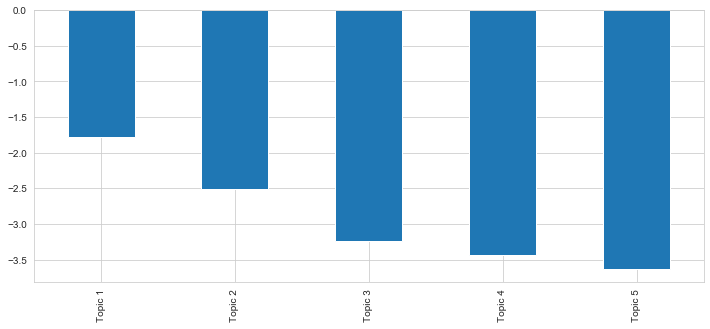

In [20]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
topic_words.head().to_csv('topic_words.csv', index=False)
print(topic_words.head())

pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(12,5));

### Using `gensim` `Dictionary` 

In [21]:
docs = [d.split() for d in train_docs.article.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

In [22]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [23]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [24]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 2175


In [25]:
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [26]:
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

In [27]:
model.show_topics()

[(0,
  '0.021*"film" + 0.020*"best" + 0.011*"music" + 0.010*"British" + 0.008*"won" + 0.007*"including" + 0.006*"UK" + 0.006*"director" + 0.006*"BBC" + 0.006*"band"'),
 (1,
  '0.011*"government" + 0.011*"Labour" + 0.008*"Blair" + 0.007*"election" + 0.007*"public" + 0.006*"say" + 0.006*"BBC" + 0.006*"Brown" + 0.006*"minister" + 0.005*"party"'),
 (2,
  '0.007*"market" + 0.007*"growth" + 0.007*"company" + 0.006*"economic" + 0.005*"sales" + 0.005*"firm" + 0.005*"economy" + 0.005*"chief" + 0.005*"oil" + 0.005*"expected"'),
 (3,
  '0.010*"mobile" + 0.008*"use" + 0.008*"technology" + 0.007*"music" + 0.007*"digital" + 0.007*"used" + 0.007*"phone" + 0.007*"users" + 0.006*"online" + 0.006*"software"'),
 (4,
  '0.011*"game" + 0.010*"England" + 0.009*"win" + 0.008*"players" + 0.007*"play" + 0.007*"good" + 0.006*"world" + 0.006*"Cup" + 0.006*"second" + 0.006*"team"')]

### Evaluating Topic Assignments on the Test Set

In [28]:
docs_test = [d.split() for d in test_docs.article.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

In [29]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4
0,70.84,7.84,0.12,0.08,21.58
1,0.08,5.47,3.77,29.08,0.10
2,0.08,0.13,15.35,56.76,2.16
3,0.08,0.13,59.73,23.46,0.10
4,0.08,0.13,8.76,0.08,29.45
5,0.08,21.69,39.26,44.34,0.10
6,4.27,0.13,60.92,0.08,0.10
7,1.47,0.13,0.12,0.08,27.70
8,0.08,0.13,73.05,9.14,0.10
9,0.08,16.45,42.78,0.08,0.10


In [30]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4
0,0.71,0.08,0.00,0.00,0.21
1,0.00,0.14,0.10,0.76,0.00
2,0.00,0.00,0.21,0.76,0.03
3,0.00,0.00,0.72,0.28,0.00
4,0.00,0.00,0.23,0.00,0.76


In [31]:
topic_probabilities.idxmax(axis=1).head()

0    0
1    3
2    3
3    2
4    4
dtype: int64

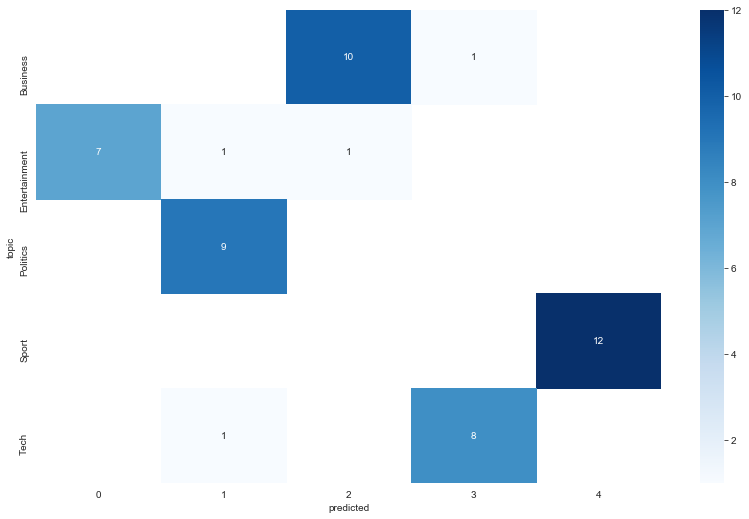

In [32]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');

## Resources

- pyLDAvis: 
    - [Talk by the Author](https://speakerdeck.com/bmabey/visualizing-topic-models) and [Paper by (original) Author](http://www.aclweb.org/anthology/W14-3110)
    - [Documentation](http://pyldavis.readthedocs.io/en/latest/index.html)
- LDA:
    - [David Blei Homepage @ Columbia](http://www.cs.columbia.edu/~blei/)
    - [Introductory Paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) and [more technical review paper](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf)
    - [Blei Lab @ GitHub](https://github.com/Blei-Lab)
    
- Topic Coherence:
    - [Exploring Topic Coherence over many models and many topics](https://www.aclweb.org/anthology/D/D12/D12-1087.pdf)
    - [Paper on various Methods](http://www.aclweb.org/anthology/N10-1012)
    - [Blog Post - Overview](http://qpleple.com/topic-coherence-to-evaluate-topic-models/)
